# O incidente do Cruzeiro Caribenho

Você recebeu uma dica anônima de que um funcionário do grupo de compras de óleos industriais esteve em um cruzeiro pelo Caribe pela terceira vez nos últimos dois anos. Como gastar além dos recursos é uma *red flag*, você inicia uma investigação.

Você solicitou uma cópia dos dados do sistema SAP. Você se concentra nos **pedidos**. Analise os dados para entender a irregularidade.

**Você pode estabelecer evidências suficientes?**

## Configuração

Algumas inicializações para facilitar

In [1]:
# Permite multiplas saídas para cada célula
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
# Mostrar gráficos 
import matplotlib.pyplot as plt
import seaborn as sns
# Bibliotecas para manipulação dos dados
import pandas as pd
import numpy as np
# Formatar número sem decimais
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Para mostrar os gráficos dentro do notebook
%matplotlib inline 

Usamos as seguintes bibliotecas:
* [Pandas](https://pandas.pydata.org) é o pacote mais importante na análise de dados.
* [Numpy](https://www.numpy.org) usada principalmente para realizar cálculos em Arrays Multidimensionais
* [Matplotlib](https://matplotlib.org/) O Matplotlib é uma biblioteca de plotagem para a linguagem de programação Python e sua extensão de matemática numérica NumPy.
* [Seaborn](https://seaborn.pydata.org/) O Seaborn é uma biblioteca de visualização de dados Python baseada no matplotlib. Ele fornece uma interface de alto nível para desenhar gráficos estatísticos atraentes e informativos.

Você recebeu três tabelas do sistema SAP que contêm todas as informações da etapa `pedido de compra`:

1. As informações do cabeçalho dos pedidos são armazenadas na tabela `EKKO`.

2. Os itens dos documentos de compra são armazenados na tabela `EKPO`.

3. Os conjuntos de condições aplicáveis associadas aos pedidos de compra estão armazenados na tabela `KONV`.

In [2]:
ekko = pd.read_csv('EKKO.csv')
ekpo = pd.read_csv('EKPO.csv')
konv = pd.read_csv('KONV.csv')

As tabelas possuem um grande número de colunas.

## Entendendo os dados

Você pode encontrar a definição de todas as colunas no sistema SAP usando o código de transação `SE16`.

Vamos ver o nome das colunas das 3 tabelas:

In [3]:
ekko.columns
ekpo.columns
konv.columns

Index(['MANDT', 'EBELN', 'BUKRS', 'BSTYP', 'BSART', 'BSAKZ', 'LOEKZ', 'STATU',
       'AEDAT', 'ERNAM',
       ...
       'OTB_RES_VALUE', 'OTB_SPEC_VALUE', 'SPR_RSN_PROFILE', 'BUDG_TYPE',
       'OTB_STATUS', 'OTB_REASON', 'CHECK_TYPE', 'CON_OTB_REQ',
       'CON_PREBOOK_LEV', 'CON_DISTR_LEV'],
      dtype='object', length=137)

Index(['MANDT', 'EBELN', 'EBELP', 'LOEKZ', 'STATU', 'AEDAT', 'TXZ01', 'MATNR',
       'EMATN', 'BUKRS',
       ...
       'FSH_SS', 'FSH_GRID_COND_REC', 'FSH_PSM_PFM_SPLIT', 'CNFM_QTY',
       'REF_ITEM', 'SOURCE_ID', 'SOURCE_KEY', 'PUT_BACK', 'POL_ID',
       'CONS_ORDER'],
      dtype='object', length=300)

Index(['MANDT', 'KNUMV', 'KPOSN', 'STUNR', 'ZAEHK', 'KAPPL', 'KSCHL', 'KDATU',
       'KRECH', 'KAWRT', 'KBETR', 'WAERS', 'KKURS', 'KPEIN', 'KMEIN', 'KUMZA',
       'KUMNE', 'KNTYP', 'KSTAT', 'KNPRS', 'KRUEK', 'KRELI', 'KHERK', 'KGRPE',
       'KOUPD', 'KOLNR', 'KNUMH', 'KOPOS', 'KVSL1', 'SAKN1', 'MWSK1', 'KVSL2',
       'SAKN2', 'MWSK2', 'LIFNR', 'KUNNR', 'KDIFF', 'KWERT', 'KSTEU', 'KINAK',
       'KOAID', 'ZAEKO', 'KMXAW', 'KMXWR', 'KFAKTOR', 'KDUPL', 'KFAKTOR1',
       'KZBZG', 'KSTBS', 'KONMS', 'KONWS', 'KAWRT_K', 'KWAEH', 'KWERT_K',
       'KFKIV', 'KVARC', 'KMPRS', 'PRSQU', 'VARCOND', 'STUFE', 'WEGXX',
       'KTREL', 'MDFLG', 'TXJLV', 'KBFLAG', 'KOLNR3', 'CPF_GUID', 'KAQTY'],
      dtype='object')

In [4]:
# Mostrando a quantidade de linhas e colunas dos datasets
print('A Tabela ekko contém {} linhas e {} colunas'.format(ekko.shape[0],ekko.shape[1]))
print('A Tabela ekpo contém {} linhas e {} colunas'.format(ekpo.shape[0],ekpo.shape[1]))
print('A Tabela konv contém {} linhas e {} colunas'.format(konv.shape[0],konv.shape[1]))

A Tabela ekko contém 567 linhas e 137 colunas
A Tabela ekpo contém 522 linhas e 300 colunas
A Tabela konv contém 3058 linhas e 68 colunas


### A tabela EKKO 

Para nossos propósitos, usaremos as seguintes colunas da tabela `EKKO`:

* `EBELN` - Contém o número do pedido de compra.

* `ERNAM` - Contém o funcionário do grupo de compras que autorizou o pedido.

* `LIFNR` - Contém o identificador exclusivo do fornecedor que recebeu o pedido.

* `KNUMV` - Contém o link para o conjunto de condições associadas ao pedido de compra.

### A tabela EKPO 

Para nossos propósitos, usaremos as seguintes colunas da tabela `EKPO`:

* `EBELN` - Contém o número do pedido de compra.

* `EBELP` - contém o identificador do item de linha.

* `TXZ01` - Contém uma descrição textual do material.

* `MATNR` - Contém o identificador exclusivo do material.

* `MENGE` - Contém a quantidade de material solicitado.

* `NETPR` - Contém o preço líquido efetivo do material pedido.

* `NETWR` - Contém o valor líquido efetivo do material pedido (ou seja,` MENGE * NETPR`).

### A tabela KONV

Para nossos propósitos, usaremos as seguintes colunas da tabela `KONV`:

* `KNUMV` - Contém o identificador exclusivo para o conjunto de condições.

* `KPOSN` - Contém o identificador do item de linha.

* `KSCHL` - Contém o tipo de uma condição.

* `KAWRT` - Contém o valor base que o sistema usa para calcular o preço da condição.

* `KBETR` - Contém o preço efetivo.

Os seguintes tipos de condição são relevantes para este estudo de caso:

* `PBXX` - Preço bruto

* `RB00` - Descontos absolutos

* `NAVM` - deduções fiscais

* `SKTO` - descontos à vista relacionados às metas de pagamento

* `WOTB` - Preço efetivo

A variável a seguir contém todos os tipos de condições relevantes.

In [5]:
tipo_cond = ['NAVM','PBXX','RB00','SKTO','WOTB']

## Limpar os dados

Reduziremos a tabela`EKKO` para as colunas do nosso interesse. 

In [6]:
ekko = ekko.loc[:, ['EBELN','ERNAM','LIFNR','KNUMV']]

As 5 primeiras linhas da tabela `ekko`.

In [7]:
ekko.head()

,EBELN,ERNAM,LIFNR,KNUMV
0,4500000000.0000,COCCHI,101999.0000,1000000000.0000
1,4500000001.0000,GBI-085,125000.0000,1000000020.0000
2,4500000002.0000,GBI-085,125000.0000,1000000021.0000
3,4500000003.0000,GBI-085,125000.0000,1000000022.0000
4,4500000004.0000,GBIFAC-01,125000.0000,1000000023.0000


Reduziremos a tabela `EKPO` para as colunas do nosso interesse. 

In [9]:
ekpo = ekpo.loc[:, ['EBELN','EBELP','TXZ01','MATNR','MENGE', 'NETPR', 'NETWR']]

As 5 primeiras linhas da tabela `ekpo`.

In [10]:
ekpo.head()

,EBELN,EBELP,TXZ01,MATNR,MENGE,NETPR,NETWR
0,4500000000,10,Off Road Helmet,OHMT1999,19689,25.0000,1500.0000
1,4500000000,20,Road Helmet,RHMT1999,150,25.0000,3750.0000
2,4500000001,10,Brent Crude Oil,BRENTCRUDE,20193,4335.0000,87536655.0000
3,4500000002,10,Brent Crude Oil,BRENTCRUDE,20103,4360.0000,87649080.0000
4,4500000003,10,Brent Crude Oil,BRENTCRUDE,20013,4340.0000,86856420.0000


Reduziremos a tabela `KONV` para as colunas do nosso interesse. 

In [11]:
konv = konv.loc[:, ['KNUMV','KPOSN','KSCHL','KAWRT', 'KBETR']]

As 5 primeiras linhas da tabela `konv`.

In [12]:
konv.head()

,KNUMV,KPOSN,KSCHL,KAWRT,KBETR
0,1,10,PR00,20.0000,3000.0000
1,1,10,SKTO,6000.0000,0.0000
2,1,10,VPRS,20.0000,1400.0000
3,2,10,PR00,50.0000,3000.0000
4,2,10,SKTO,15000.0000,0.0000


## Foco na *[Brent](https://pt.wikipedia.org/wiki/Brent_(petr%C3%B3leo)) Crude Oil (Óleo cru de Brent)

Vamos filtrar as linhas dos itens que contém pedidos para a Brent Crude Oil (`MATNR`: `BRENTCRUDE`). Armazenaremos em uma variável chamada `ekpo_bco`.

In [13]:
ekpo_bco = ekpo[ekpo['MATNR']=='BRENTCRUDE']
ekpo_bco.head()

,EBELN,EBELP,TXZ01,MATNR,MENGE,NETPR,NETWR
2,4500000001,10,Brent Crude Oil,BRENTCRUDE,20193,4335.0000,87536655.0000
3,4500000002,10,Brent Crude Oil,BRENTCRUDE,20103,4360.0000,87649080.0000
4,4500000003,10,Brent Crude Oil,BRENTCRUDE,20013,4340.0000,86856420.0000
5,4500000004,10,Brent Crude Oil,BRENTCRUDE,20154,4307.5000,83319972.5000
6,4500000005,10,Brent Crude Oil,BRENTCRUDE,19985,4277.5000,85485837.5000


Quantos pedidos foram feitos para a Brent Crude Oil?

In [14]:
print('Foram feitos {} pedidos de Brent Crude Oil'.format(len(ekpo_bco)))

Foram feitos 29 pedidos de Brent Crude Oil


## O valor dos pedidos de compra da Brent Crude Oil 

Qual é o valor geral de todas as ordens de compra da Brent Crude Oil?

In [15]:
print('O valor total dos pedidos foram de:$ {:7,.2f}'.format(ekpo_bco['NETWR'].sum()))

O valor total dos pedidos foram de:$ 2,536,790,085.00


Qual a média dos preços líquidos efetivos(`NETPR`)?

In [16]:
ekpo_bco['NETPR'].mean()

4384.827586206897

Vamos visualizar como os preços líquidos efetivos (`NETPR`) de todos os pedidos de Brent Crude Oil mudam ao longo do tempo. *(Assuma que a ordem dos pedidos de compra represente tempo)*

<Figure size 864x432 with 0 Axes>

[Text(0, 0.5, 'Preço Líquido Efetivo do Petróleo Brent'),
 Text(0.5, 0, 'Ordem de Compra')]

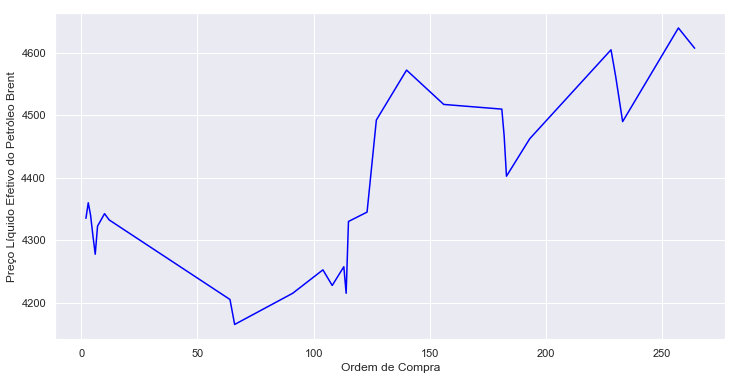

In [17]:
plt.figure(figsize=(12,6))

sns.set(style="darkgrid")
ax = sns.lineplot(x=ekpo_bco.index, y ="NETPR",data=ekpo_bco,color="blue")
ax.set(xlabel='Ordem de Compra', ylabel='Preço Líquido Efetivo do Petróleo Brent')

plt.show()


**Reflita:** Qual é a sua interpretação do preço líquido efetivo?

## O volume dos pedidos de compra de petróleo Brent

Qual é o volume médio dos pedidos de petróleo brent?

In [18]:
ekpo_bco['MENGE'].mean()

19977.724137931036

Mostrando a quantidade de todos os pedidos (`MENGE`) de petróleo Brent. (Assuma que a ordem dos pedidos de compra represente tempo).

<Figure size 864x432 with 0 Axes>

[Text(0, 0.5, 'Volume de pedidos de Brent Crude Oil'),
 Text(0.5, 0, 'Ordem de Compra')]

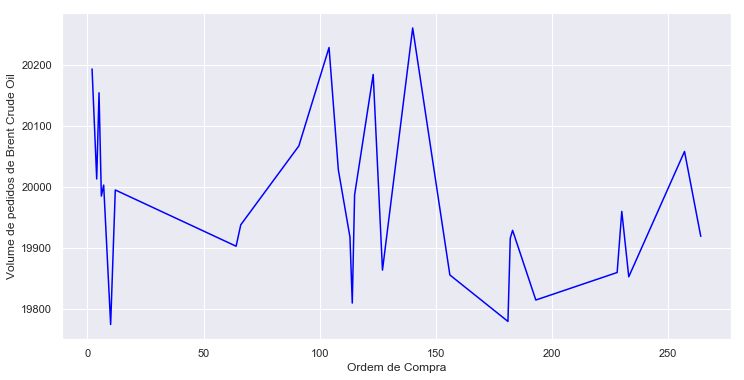

In [19]:
plt.figure(figsize=(12,6))

sns.set(style="darkgrid")
ax = sns.lineplot(x=ekpo_bco.index, y ="MENGE",data=ekpo_bco,color="blue")
ax.set(xlabel='Ordem de Compra', ylabel='Volume de pedidos de Brent Crude Oil')

plt.show()


**Reflita:** Qual é a sua interpretação do volume de pedidos?

## Análise integrada de `EKKO` e `EKPO`

Vamos fazer uma *left join* das tabelas `ekpo_bco` e `ekko`. Armazenaremos em uma variável chamada `ekko_ekpo_bco`.

In [20]:
ekko_ekpo_bco = pd.merge(ekpo_bco, ekko, on='EBELN')
ekko_ekpo_bco.head()

,EBELN,EBELP,TXZ01,MATNR,MENGE,NETPR,NETWR,ERNAM,LIFNR,KNUMV
0,4500000001,10,Brent Crude Oil,BRENTCRUDE,20193,4335.0000,87536655.0000,GBI-085,125000.0000,1000000020.0000
1,4500000002,10,Brent Crude Oil,BRENTCRUDE,20103,4360.0000,87649080.0000,GBI-085,125000.0000,1000000021.0000
2,4500000003,10,Brent Crude Oil,BRENTCRUDE,20013,4340.0000,86856420.0000,GBI-085,125000.0000,1000000022.0000
3,4500000004,10,Brent Crude Oil,BRENTCRUDE,20154,4307.5000,83319972.5000,GBIFAC-01,125000.0000,1000000023.0000
4,4500000005,10,Brent Crude Oil,BRENTCRUDE,19985,4277.5000,85485837.5000,GBIFAC-01,125000.0000,1000000024.0000


Quantos fornecedores(`LIFNR`) entregam Brent crude oil?

In [21]:
ekko_ekpo_bco['LIFNR'].unique()

array([125000.])

Podemos ver que a empresa em questão só comprou Brent Crude Oil de um único fornecedor!

Quantos funcionários do grupo de compras (ERNAM) são responsáveis pelos pedidos de Brent Crude Oil?

In [22]:
func_unicos = ekko_ekpo_bco['ERNAM'].unique()
func_unicos

array(['GBI-085', 'GBIFAC-01'], dtype=object)

Podemos ver que somente 2 funcionários autorizaram compras de Brent Crude Oil no período avaliado!!!!

Existem diferenças no volume médio de pedidos entre os funcionários do grupo de compras(`ERNAM`)?

In [23]:
vol_med = ekko_ekpo_bco.groupby('ERNAM')['MENGE'].mean()
vol_med

ERNAM
GBI-085     20118.8889
GBIFAC-01   19914.2000
Name: MENGE, dtype: float64

Mostrando a evolução da quantidade de todos os pedidos (MENGE) de petróleo Brent dos 2 funcionários citados acima. (Assuma que a ordem dos pedidos de compra represente tempo).

<Figure size 864x432 with 0 Axes>

[Text(0, 0.5, 'Volume de pedidos de Brent Crude Oil'),
 Text(0.5, 0, 'Ordem de Compra')]

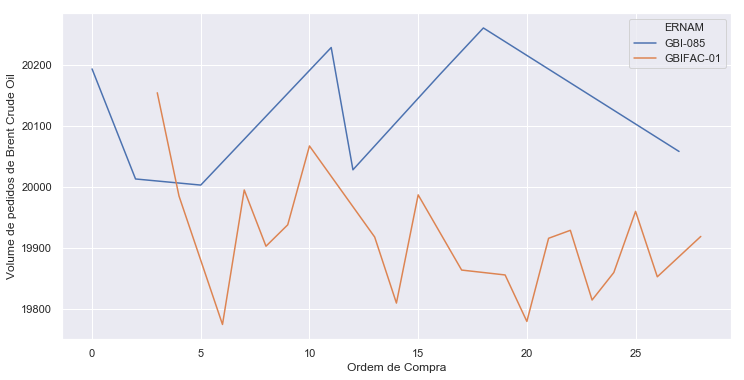

In [24]:
plt.figure(figsize=(12,6))

sns.set(style="darkgrid")
ax = sns.lineplot(x=ekko_ekpo_bco.index, y =ekko_ekpo_bco["MENGE"],
                  data= ekko_ekpo_bco, color = 'r', hue = ekko_ekpo_bco.ERNAM)
ax.set(xlabel='Ordem de Compra', ylabel='Volume de pedidos de Brent Crude Oil')

plt.show()


## Análise das condições

Filtrar as condições para o pedidos de compra de Brent Crude Oil! Armazene o resultado em uma variável chamada`konv_bco`.

In [25]:
konv_bco = konv[konv['KNUMV'].isin(ekko_ekpo_bco['KNUMV'])]

Vamos ver as 5 primeiras linhas da tabela `konv_bco`.

In [26]:
konv_bco.head()

,KNUMV,KPOSN,KSCHL,KAWRT,KBETR
52,1000000020,10,PBXX,1000.0000,4336.2400
53,1000000020,10,RB00,87561655.0000,-25000.0000
54,1000000020,10,NAVM,87536655.0000,0.0000
55,1000000020,10,SKTO,87536655.0000,0.0000
56,1000000020,10,WOTB,1000.0000,4335.0000


Qual é o tipo de condição interessante?

In [27]:
konv_bco.groupby('KSCHL')[['KSCHL']].count()

,KSCHL
KSCHL,
NAVM,29
PBXX,29
RB00,11
SKTO,29
WOTB,29


Interessante, somente a condição `RB00`(descontos absolutos) diverge das demais.

Adicione **dummies** para o tipo de condição ao konv_bco. Armazenar o resultado em uma variável chamada `konv_bco_d`?

**Obs** - Variável dummy é uma variável categórica que foi transformada em numérica, por exemplo, em uma pesquisa feita com 10 pessoas, 7 eram do sexo masculino e 3 do feminino. Como “feminino” e “masculino” são categorias de sexo, como poderíamos transformá-las em números? Uma maneira de se fazer isso é atribuir, por exemplo, o número 0 a categoria “masculino” e o número 1 a categoria “feminino”.

In [28]:
konv_bco_d = konv_bco.join(konv_bco['KSCHL'].str.get_dummies())

Vamos ver as 5 primeiras linhas da tabela`konv_bco_d`.

In [29]:
konv_bco_d.head()

,KNUMV,KPOSN,KSCHL,KAWRT,KBETR,NAVM,PBXX,RB00,SKTO,WOTB
52,1000000020,10,PBXX,1000.0000,4336.2400,0,1,0,0,0
53,1000000020,10,RB00,87561655.0000,-25000.0000,0,0,1,0,0
54,1000000020,10,NAVM,87536655.0000,0.0000,1,0,0,0,0
55,1000000020,10,SKTO,87536655.0000,0.0000,0,0,0,1,0
56,1000000020,10,WOTB,1000.0000,4335.0000,0,0,0,0,1


Vamos filtrar os conjuntos de condições que contêm o tipo de condição de interesse. Armazene o resultado em uma variável chamada `rb00`(Lembre-se que o código RB00 significa descontos absolutos).

In [30]:
rb00 = konv_bco_d.groupby('KNUMV')['RB00'].sum().reset_index()

In [31]:
rb00

,KNUMV,RB00
0,1000000020,1
1,1000000021,1
2,1000000022,1
3,1000000023,1
4,1000000024,0
5,1000000025,1
6,1000000028,0
7,1000000030,0
8,1000000080,0
9,1000000082,0


Vamos fazer uma *left join* e juntar o tipo de condição de interesse às outras tabelas. Vamos armazenar o resultado em uma variável chamada`eek_bco`.

In [32]:
eek_bco = pd.merge(ekko_ekpo_bco, rb00, on='KNUMV', how='left')
eek_bco

,EBELN,EBELP,TXZ01,MATNR,MENGE,NETPR,NETWR,ERNAM,LIFNR,KNUMV,RB00
0,4500000001,10,Brent Crude Oil,BRENTCRUDE,20193,4335.0000,87536655.0000,GBI-085,125000.0000,1000000020.0000,1
1,4500000002,10,Brent Crude Oil,BRENTCRUDE,20103,4360.0000,87649080.0000,GBI-085,125000.0000,1000000021.0000,1
2,4500000003,10,Brent Crude Oil,BRENTCRUDE,20013,4340.0000,86856420.0000,GBI-085,125000.0000,1000000022.0000,1
3,4500000004,10,Brent Crude Oil,BRENTCRUDE,20154,4307.5000,83319972.5000,GBIFAC-01,125000.0000,1000000023.0000,1
4,4500000005,10,Brent Crude Oil,BRENTCRUDE,19985,4277.5000,85485837.5000,GBIFAC-01,125000.0000,1000000024.0000,0
5,4500000006,10,Brent Crude Oil,BRENTCRUDE,20003,4322.5000,86462967.5000,GBI-085,125000.0000,1000000025.0000,1
6,4500000009,10,Brent Crude Oil,BRENTCRUDE,19775,4342.5000,85872937.5000,GBIFAC-01,125000.0000,1000000028.0000,0
7,4500000011,10,Brent Crude Oil,BRENTCRUDE,19995,4332.5000,86628337.5000,GBIFAC-01,125000.0000,1000000030.0000,0
8,4500000061,10,Brent Crude Oil,BRENTCRUDE,19903,4205.0000,83692115.0000,GBIFAC-01,125000.0000,1000000080.0000,0
9,4500000063,10,Brent Crude Oil,BRENTCRUDE,19938,4165.0000,83041770.0000,GBIFAC-01,125000.0000,1000000082.0000,0


## Qual a fraude?

O que o fraudador explora?

In [33]:
eek_bco[eek_bco['RB00']==1]['MENGE'].agg(['min','max'])

min    20003
max    20260
Name: MENGE, dtype: int64

In [34]:
eek_bco[eek_bco['RB00']==0]['MENGE'].agg(['min','max'])

min    19775
max    19995
Name: MENGE, dtype: int64

Quem é a pessoa de interesse?

In [35]:
eek_bco.groupby('RB00')[['MENGE', 'ERNAM']].agg({'MENGE': 'mean', 'ERNAM':'unique'})

,MENGE,ERNAM
RB00,,
0,19892.3889,[GBIFAC-01]
1,20117.3636,"[GBI-085, GBIFAC-01]"


Qual é o dano financeiro?

In [36]:
abs((len(ekko_ekpo_bco) - len(konv_bco[konv_bco['KSCHL']=='RB00'])) *\
konv_bco[konv_bco['KSCHL']=='RB00']['KBETR'].unique()[0])

450000.0

Você consegue explicar a fraude?

Obviamente esse exercício visa fazer os leitores pensarem "fora da caixa". As análises aqui realizadas não esgotam outras análises mais elaboradas, e consequentemente, em uma auditoria real necessitaríamos de outras análises e documentos suportes para podermos dar um parecer sobre a real existência ou não de fraude.
Venho reforçar também como a análise de dados através de métodos estatísticos e ciência de dados, aliada ao ceticismo, pensamento análitico e criatividade tende a ser uma ferramenta poderosa no auxílio da auditoria interna.